# **Import Libary**

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callback.wandb import *
from PIL import Image, ImageOps
from fastai.vision.data import ImageDataLoaders

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,5)
plt.style.use('fivethirtyeight')
from fastai.vision.all import *
import timm
import warnings 
import albumentations
from albumentations.pytorch import ToTensorV2
warnings.filterwarnings('ignore')

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: teetouchoo. Use `wandb login --relogin` to force relogin


True

In [ ]:
def random_seed(seed_value, use_cuda): 
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value) 
# cpu  vars
    random.seed(seed_value)
 # Python 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value) 
        torch.cuda.manual_seed_all(seed_value) 
# gpu vars
        torch.backends.cudnn.deterministic = True 
 #needed
        torch.backends.cudnn.benchmark = False 
#Remember to use num_workers=0 when creating the DataBunch.

random_seed(2023,True)

In [ ]:
class AlbumentationsTransform (RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    


# **Data Augmentation**

In [ ]:
#train_data = pd.read_csv('train_new.csv')
#train_data

train_data = pd.read_csv('train_data.csv')
train_data

,filename,label,target
0,contrast/contrast/im_1000.png,0,0
1,contrast/contrast/im_10000.png,0,0
2,contrast/contrast/im_10001.png,0,0
3,contrast/contrast/im_10004.png,2,1
4,contrast/contrast/im_10005.png,0,0
...,...,...,...
44338,contrast/contrast/im_9991.png,0,0
44339,contrast/contrast/im_9992.png,0,0
44340,contrast/contrast/im_9994.png,0,0
44341,contrast/contrast/im_9997.png,0,0


In [ ]:
import numpy as np

def auto_contrast(img):
    # Compute the histogram
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])

    # Find the minimum and maximum intensity values
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    cdf_m = np.ma.masked_equal(cdf_normalized, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, 0).astype('uint8')
    min_intensity = np.argmin(cdf)
    max_intensity = np.argmax(cdf)

    # Compute the scaling factor
    scale_factor = 255.0 / (max_intensity - min_intensity)

    # Apply auto contrast
    img = (img - min_intensity) * scale_factor
    img = np.clip(img, 0, 255)

    # Return the output image
    return img.astype('uint8')

from albumentations import ImageOnlyTransform

class AutoContrast(ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super().__init__(always_apply=always_apply, p=p)

    def apply(self, img, **params):
        return auto_contrast(img)
        
    def get_transform_init_args_names(self):
        return ()

In [ ]:
size = 448
def get_train_aug(): return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=size, width=size, interpolation=0),
            #AutoContrast(),
            #albumentations.PadIfNeeded(always_apply=False, p=1.0, min_height=size, min_width=size, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            albumentations.Rotate(limit=(-180, 180)),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            #albumentations.Sharpen(always_apply=False, p=1.0, alpha=(0.2, 0.5), lightness=(0.5, 1.0)),

            #albumentations.ShiftScaleRotate(always_apply=False, p=1.0, shift_limit_x=(-0.06, 0.06), shift_limit_y=(-0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-20, 20), interpolation=0, border_mode=0, value=(255, 255, 255), mask_value=None, rotate_method='largest_box'),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            #albumentations.ColorJitter(contrast=(0.9, 1.1)),
            #albumentations.CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4), tile_grid_size=(8, 8)),
            # albumentations.RandomBrightnessContrast(
            #     brightness_limit=(-0.1,0.1), 
            #     contrast_limit=(-0.1, 0.1), 
            #     p=0.5
            # ),
            #albumentations.RandomGamma(),
            #albumentations.ToGray(always_apply=False, p=1.0)
            
           #albumentations.RandomGridShuffle(p=0.5)\
    ], p=1.)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=size, width=size, interpolation=0),
  
            #albumentations.PadIfNeeded(always_apply=False, p=1.0, min_height=size, min_width=size, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None),
            #albumentations.ToGray(always_apply=False, p=1.0),
            #AutoContrast(),
             
            ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [ ]:
blocks = (ImageBlock, CategoryBlock)
splitter = TrainTestSplitter(0.15, stratify=train_data["label"],random_state=42,shuffle=True)
block = DataBlock(blocks = blocks,
                 get_x=ColReader(0),
                 get_y=ColReader(1),
                 splitter = splitter,
                 item_tfms = item_tfms,
                 batch_tfms = batch_tfms)

dls = block.dataloaders(train_data, bs=16)

In [ ]:
# to view
dls.show_batch(max_n=8,nrows=2)

# **Model**

In [ ]:
import timm

timm.list_models('eva*')

['eva02_base_patch14_224',
 'eva02_base_patch14_448',
 'eva02_base_patch16_clip_224',
 'eva02_enormous_patch14_clip_224',
 'eva02_large_patch14_224',
 'eva02_large_patch14_448',
 'eva02_large_patch14_clip_224',
 'eva02_small_patch14_224',
 'eva02_small_patch14_336',
 'eva02_tiny_patch14_224',
 'eva02_tiny_patch14_336',
 'eva_giant_patch14_224',
 'eva_giant_patch14_336',
 'eva_giant_patch14_560',
 'eva_large_patch14_196',
 'eva_large_patch14_336']

In [ ]:
from fastai.callback.wandb import *
learn = vision_learner(dls,'eva02_large_patch14_448', metrics=accuracy, path=".",cbs= [SaveModelCallback(monitor='valid_loss'),WandbCallback()])
#learn = vision_learner(dls,'eva02_large_patch14_224', metrics=accuracy, path=".",cbs= [SaveModelCallback(monitor='valid_loss')])
learn.to_fp16()

In [ ]:
from fastai.callback.wandb import *
wandb.init(project='Diabetic_augment')

In [ ]:
#learn.fit_one_cycle(10, slice(1e-5,1e-4))
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.701718,0.682512,0.791341,21:59


Better model found at epoch 0 with valid_loss value: 0.6825124621391296.


epoch,train_loss,valid_loss,accuracy,time
0,0.567024,0.565019,0.815995,26:37
1,0.548721,0.505649,0.836891,26:36
2,0.467946,0.481805,0.846512,26:37
3,0.474546,0.457284,0.855833,26:37
4,0.408741,0.451115,0.854931,26:37


Better model found at epoch 0 with valid_loss value: 0.5650194883346558.
Better model found at epoch 1 with valid_loss value: 0.5056492686271667.
Better model found at epoch 2 with valid_loss value: 0.48180532455444336.
Better model found at epoch 3 with valid_loss value: 0.45728376507759094.
Better model found at epoch 4 with valid_loss value: 0.45111510157585144.


# **Evaluation**

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(10, figsize=(75,50))

In [ ]:
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(10,10))

# **Predict**

In [ ]:
test = pd.read_csv('/content/test_submission.csv')

In [ ]:
test

,filename,target
0,im_1.png,NaN
1,im_10.png,NaN
2,im_100.png,NaN
3,im_10002.png,NaN
4,im_10003.png,NaN
...,...,...
44344,im_9988.png,NaN
44345,im_9993.png,NaN
44346,im_9995.png,NaN
44347,im_9996.png,NaN


In [ ]:
test['filename'] = test['filename'].apply(lambda x:"contrast_1/contrast/" +x)

In [ ]:
tst_dl = dls.test_dl(test.filename)

In [ ]:
tst_dl.show_batch(max_n=8,nrows=2)

In [ ]:
tta = learn.tta(dl=tst_dl, n=6)

In [ ]:
tta = learn.get_preds(dl=tst_dl)

In [ ]:
tta

(tensor([[4.3676e-02, 6.2931e-02, 8.9064e-01, 2.6487e-03, 1.0032e-04],
         [9.7830e-01, 1.9564e-02, 2.1151e-03, 2.0335e-05, 1.0651e-06],
         [8.9408e-01, 5.3563e-02, 5.0985e-02, 1.0347e-03, 3.3854e-04],
         ...,
         [9.9436e-01, 5.2154e-03, 4.2250e-04, 2.7005e-06, 3.5221e-06],
         [7.6431e-01, 1.8997e-01, 4.5100e-02, 5.2918e-04, 9.1958e-05],
         [2.7674e-02, 1.4988e-02, 8.7448e-01, 7.7538e-02, 5.3231e-03]]),
 None)

In [ ]:
tta_preds, _ = tta
idxs = tta_preds.argmax(dim=1)
vocab = np.array(dls.vocab)
sub = pd.read_csv('/content/test_submission.csv')
sub['target'] = vocab[idxs]



In [ ]:
sub

,filename,target
0,im_1.png,2
1,im_10.png,0
2,im_100.png,0
3,im_10002.png,0
4,im_10003.png,2
...,...,...
44344,im_9988.png,0
44345,im_9993.png,0
44346,im_9995.png,0
44347,im_9996.png,0


In [ ]:
sub.to_csv('RAW_6TTA_451_eva2large448_Gosubmission.csv', index=False)


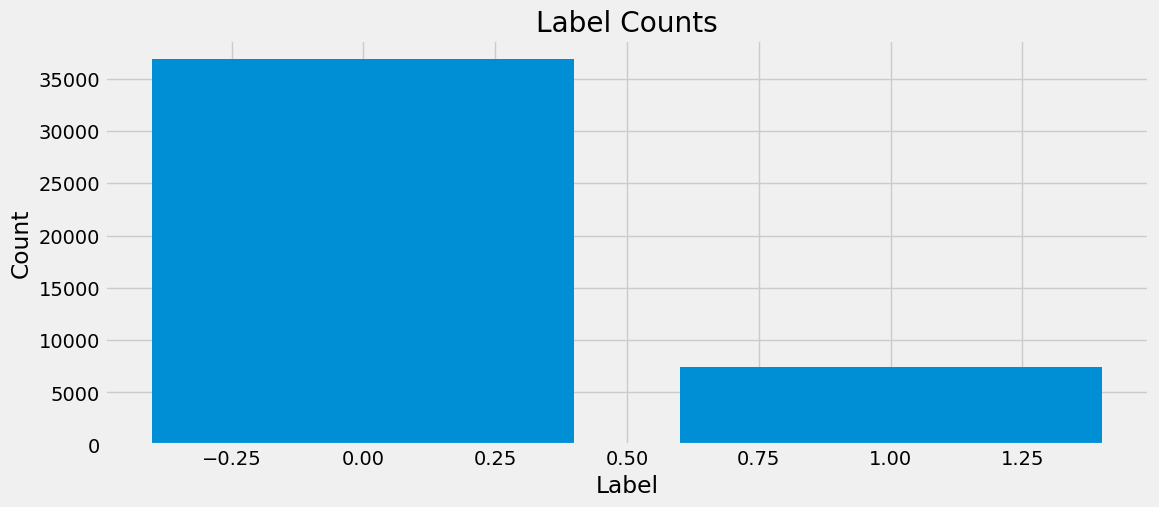

In [ ]:
import csv
import pandas as pd
import matplotlib.pyplot as plt 
#sub['filename'] = sub['filename'].apply(lambda x: x.replace('testset/contrast/contrast/',''))
sub['filename'] = sub['filename'].apply(lambda x: x.replace("test_data/croped/",''))
# Map values 0 and 1 to label 0, and 2,3,4 to label 1
sub['target'] = sub['target'].replace({0: 0, 1: 0, 2: 1, 3: 1, 4: 1})

# Get the unique values of the 'label' column
unique_labels = sub['target'].unique()

# Get the counts of each label
label_counts = sub['target'].value_counts()

# Plot the bar graph of label counts
plt.bar(label_counts.index, label_counts.values)

# Set the plot title and labels
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()

In [ ]:
sub.to_csv('6TTA_451_eva2large448_Gosubmission.csv', index=False)


In [ ]:
sub

# New Section

In [ ]:
import pandas as pd
from PIL import Image

# read in the two CSV files as pandas dataframes
df1 = pd.read_csv('TTA_114_eva2large224_Gosubmission.csv')
df2 = pd.read_csv('NOTTA_114_eva2large224_Gosubmission.csv')

df1['filename'] = df1['filename'].apply(lambda x:"data/test/test/" +x)
df2['filename'] = df2['filename'].apply(lambda x:"data/test/test/" +x)
# merge the two dataframes on the filename column
merged_df = pd.merge(df1, df2, on='filename')
merged_df
# filter the merged dataframe to only show rows where the labels don't match
mismatched_labels = merged_df[merged_df['class_x'] != merged_df['class_y']]

# loop through the mismatched rows and display the image and labels
for index, row in mismatched_labels.iterrows():
    img = Image.open(row['filename'])
    img.show()
    print(f"Label in file1: {row['class_x']}, Label in file2: {row['class_y']}")

# **LOAD PESUDO**

In [ ]:
test_data = pd.read_csv('TTA_114_eva2large224_Gosubmission.csv')
train_data = pd.read_csv('train_new.csv')
test_data = test_data.rename(columns={"filename": "image_path"})
test_data['image_path'] = test_data['image_path'].apply(lambda x:"data/test/test/" +x)
test_data = test_data.rename(columns={"class": "label"})

In [ ]:
test_data

,image_path,label
0,data/test/test/0.jpg,28
1,data/test/test/1.jpg,8
2,data/test/test/2.jpg,9
3,data/test/test/3.jpg,26
4,data/test/test/4.jpg,35
...,...,...
13594,data/test/test/13594.jpg,6
13595,data/test/test/13595.jpg,2
13596,data/test/test/13596.jpg,19
13597,data/test/test/13597.jpg,33


In [ ]:
train_data

,image_path,label
0,data/train/train/2/Set3_F1_P-0071_17.jpg,2
1,data/train/train/2/Set3_F1_P-0130_17.jpg,2
2,data/train/train/2/Set4_F1_P-0200_24.jpg,2
3,data/train/train/2/Set4_F1_P-0061_25.jpg,2
4,data/train/train/2/Set4_F1_P-0170_29.jpg,2
...,...,...
63322,data/train/train/18/Set3_M1_P-0074_48.jpg,18
63323,data/train/train/18/Set4_F1_P-0191_52.jpg,18
63324,data/train/train/18/Set4_F1_P-0232_52.jpg,18
63325,data/train/train/18/Set4_F1_P-0083_58.jpg,18


In [ ]:
pesudo = pd.concat([test_data,train_data])

In [ ]:
pesudo

,image_path,label
0,data/test/test/0.jpg,28
1,data/test/test/1.jpg,8
2,data/test/test/2.jpg,9
3,data/test/test/3.jpg,26
4,data/test/test/4.jpg,35
...,...,...
63322,data/train/train/18/Set3_M1_P-0074_48.jpg,18
63323,data/train/train/18/Set4_F1_P-0191_52.jpg,18
63324,data/train/train/18/Set4_F1_P-0232_52.jpg,18
63325,data/train/train/18/Set4_F1_P-0083_58.jpg,18


In [ ]:
pesudo.to_csv('pesudo_label.csv',index=False)